# Code for AMAS project 2
### *By Niels August Davidsen*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from iminuit import Minuit

# Seed
np.random.seed(42)


In [3]:
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

___

# Problem 1:



In [4]:
def acc_rej(N_points, f, a, b, xrange=[-1.02, 1.11], yrange=[0,2]):
    n=0
    data = []
    while n < N_points:
        x = np.random.uniform(*xrange)
        y = np.random.uniform(*yrange)
        if y < f(x, a,b):
            data.append(x)
            n+=1
    return np.array(data)

def pdf_non_normal(x, a, b):
    return 1 + x * a + b * x**2

x_min = -1.02
x_max = 1.11
a_true = 0.9
b_true = 0.55

def pdf(x, a, b):
    integral, _ = quad(pdf_non_normal, x_min, x_max, args=(a, b))
    A = 1 / integral
    return A * pdf_non_normal(x, a,b)

def llh(params, data):
    return -np.sum(np.log(pdf(data, *params)))

N_points = 807
data = acc_rej(N_points, pdf, a_true, b_true)
np.savetxt("davidsen_polynomial.txt", data)

guess = [0, 0]
res = minimize(llh, x0=guess, args=(data,), method='L-BFGS-B')
a_ml, b_ml = res.x
print(f"Maximum likelihood estimates: a={a_ml:.3f}, b={b_ml:.3f}")


Maximum likelihood estimates: a=0.771, b=0.461


In [5]:
from scipy.stats import poisson
lam_true = 3.8
Np = 513

data_poisson = poisson.rvs(lam_true, size=Np)
np.savetxt("davidsen_poisson.txt", data_poisson)   
def llh_poisson(lam, data):
    return -np.sum(np.log(poisson.pmf(data, lam)))

guess = [2]
res = minimize(llh_poisson, x0=guess, args=(data_poisson,), method='L-BFGS-B')
lam_ml = res.x[0]
print(f"Maximum likelihood estimate: lambda={lam_ml:.3f}")


Maximum likelihood estimate: lambda=3.667


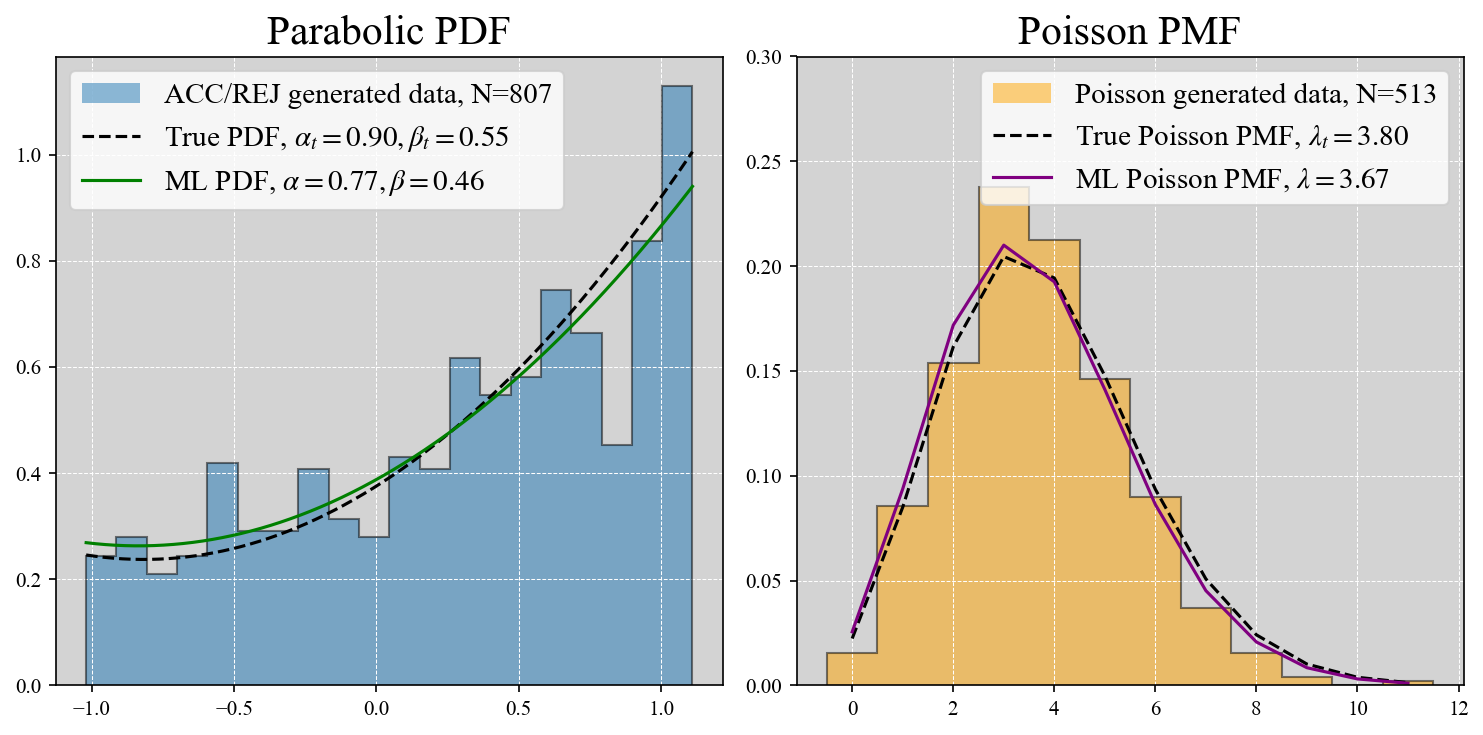

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
hist_range = [-1.02, 1.11]
ax[0].hist(data, range=hist_range, bins=20, label=f'ACC/REJ generated data, N={len(data)}', alpha=0.5, density=True, histtype='stepfilled');
ax[0].hist(data, range=hist_range, bins=20, alpha=0.5, density=True, histtype='step', color='k');
x = np.linspace(*hist_range, 1000)

ax[0].plot(x, 
           pdf(x, a_true, b_true), 
           label=r'True PDF, $\alpha_t = {:.2f}, \beta_t = {:.2f}$'.format(a_true, b_true), 
           lw=1.5, 
           color='k', 
           ls='--')

ax[0].plot(x, 
           pdf(x, a_ml, b_ml), 
           label=r'ML PDF, $\alpha = {:.2f}, \beta = {:.2f}$'.format(a_ml, b_ml), 
           lw=1.5, color='green', 
           ls='-')
ax[0].set_title('Parabolic PDF', fontsize=20)


hist_range = [-0.5, 11.5]
ax[1].hist(data_poisson, range=hist_range, bins=12, label=f'Poisson generated data, N={len(data_poisson)}', alpha=0.5, density=True, histtype='stepfilled', color='orange');
ax[1].hist(data_poisson, range=hist_range, bins=12, alpha=0.5, density=True, histtype='step', color='k');
x = np.arange(hist_range[0] + 0.5, hist_range[1] + 0.5, 1)
ax[1].plot(x, 
           poisson.pmf(x, lam_true), 
           label=r'True Poisson PMF, $\lambda_t = {:.2f}$'.format(lam_true), 
           lw=1.5, 
           color='k', 
           ls='--')

ax[1].plot(x, poisson.pmf(x, lam_ml), 
           label=r'ML Poisson PMF, $\lambda = {:.2f}$'.format(lam_ml), 
           lw=1.5, 
           color='purple', 
           ls='-')

ax[1].set_ylim(0, 0.3)
ax[1].set_title('Poisson PMF', fontsize=20)


for a in ax:
    a.set_facecolor('lightgrey')
    a.grid(color='white', which='both', linestyle='--', lw=0.5) 
    a.legend(fontsize=14)

plt.tight_layout()


___ 

# Problem 2:



In [7]:
from matplotlib.path import Path

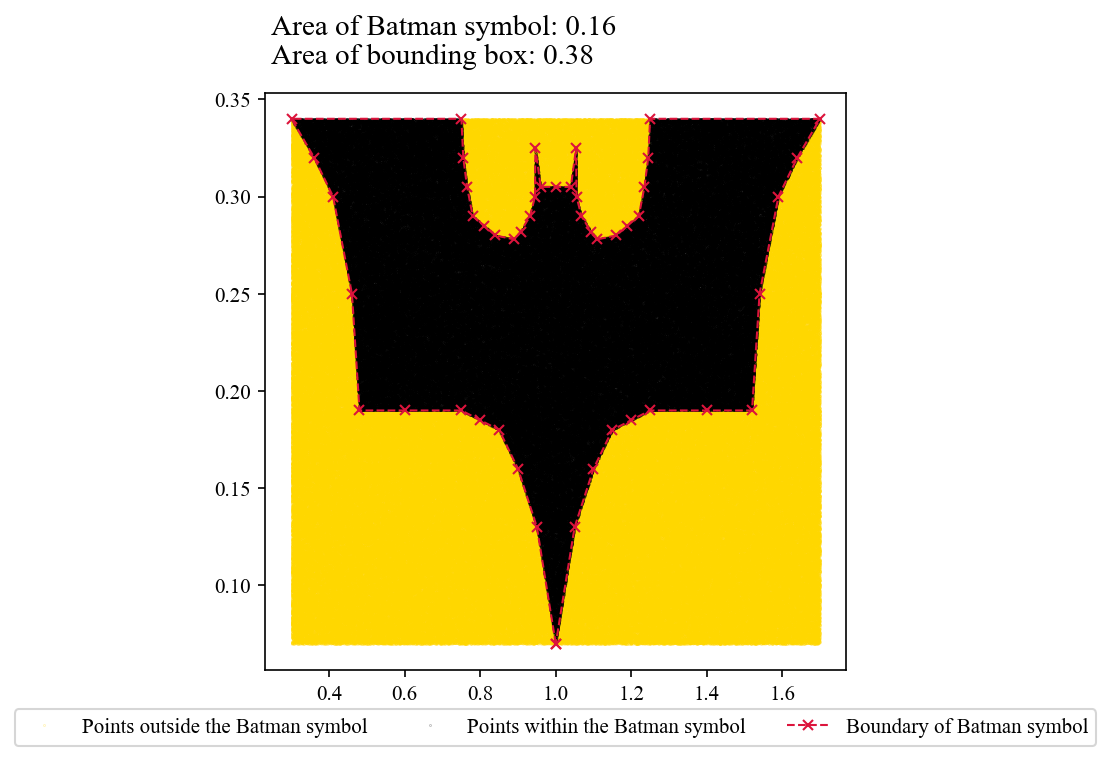

In [ ]:
boundary_points = np.loadtxt("OutlineAreaSpline.txt", skiprows=1, usecols=(0,1))
x = boundary_points[:,0]
y = boundary_points[:,1]

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

N_samples = int(1e6)
x_samples = np.random.uniform(x_min, x_max, N_samples)
y_samples = np.random.uniform(y_min, y_max, N_samples)

path = Path(boundary_points, )
inside = path.contains_points(np.column_stack((x_samples, y_samples)))
x_inside = x_samples[inside]
y_inside = y_samples[inside]
x_outside = x_samples[~inside]
y_outside = y_samples[~inside]

area_square = (x_max - x_min) * (y_max - y_min)
area = len(x_inside) * area_square / N_samples 


fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(x_outside, y_outside, color='gold', ls='', marker='o', markersize=.1, label='Points outside the Batman symbol')
ax.plot(x_inside, y_inside, color='k', ls='', marker='o', markersize=.1, label='Points within the Batman symbol')
ax.plot(x, y, color='crimson', ls='--', marker='x', markersize=3, lw='1', label='Boundary of Batman symbol')
ax.text(0.01, 1.1, f"Area of Batman symbol: {area:.2f}", transform=ax.transAxes, fontsize=14)
ax.text(0.01, 1.05, f"Area of bounding box: {area_square:.2f}", transform=ax.transAxes, fontsize=14)


ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

